# EV Elasticity: Estimation of the Value of Time

## 0. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## 1. Approximation of Empirical Distribution from reference paper
__Paper:__ [Vehicle-to-grid and car sharing: Willingness for flexibility in reservation times in Switzerland](https://www.sciencedirect.com/science/article/pii/S136192092300411X), Figure 3

In [2]:
# Approximated data from the histogram
bin_centers = np.linspace(22, 36, 28) # Bin centers
counts = np.array([1,1,1,4,0,0,0,3,0,7,15,19,37,25,22,40,60,90,104,91,55,63,64,37,25,7,4,2])  # Estimated cumulative counts

In [3]:
# Conversion rate from CHF to USD
conversion_rate = 1.13

# GDP per capita adjustment factor
gdp_ch = 99994  # Switzerland GDP per capita
gdp_new_england = 84340  # New England GDP per capita
gdp_adjustment_factor = gdp_new_england / gdp_ch

# Convert bin centers from CHF to USD and adjust for GDP per capita
bin_centers_adjusted = np.round(bin_centers * conversion_rate * gdp_adjustment_factor, 1)

# Display the adjusted bin centers
bin_centers_adjusted

array([21. , 21.5, 22. , 22.5, 22.9, 23.4, 23.9, 24.4, 24.9, 25.4, 25.9,
       26.4, 26.9, 27.4, 27.9, 28.4, 28.9, 29.4, 29.9, 30.4, 30.9, 31.3,
       31.8, 32.3, 32.8, 33.3, 33.8, 34.3])

## 2. Plots

### Value of Time

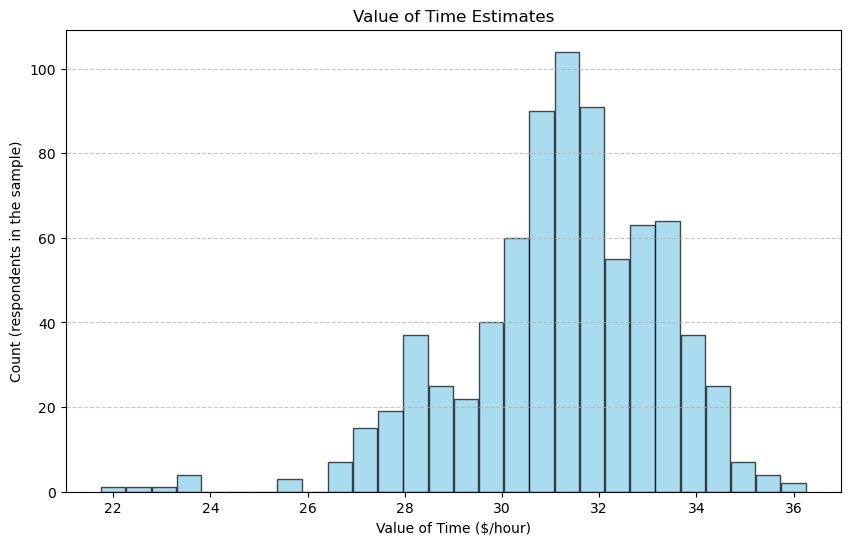

In [4]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, counts, width=0.5, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Value of Time Estimates')
plt.xlabel('Value of Time ($/hour)')
plt.ylabel('Count (respondents in the sample)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Preference parameter alpha
$
\text{Value of time} = 1/2 \ \alpha \ (\Delta t)^2
$

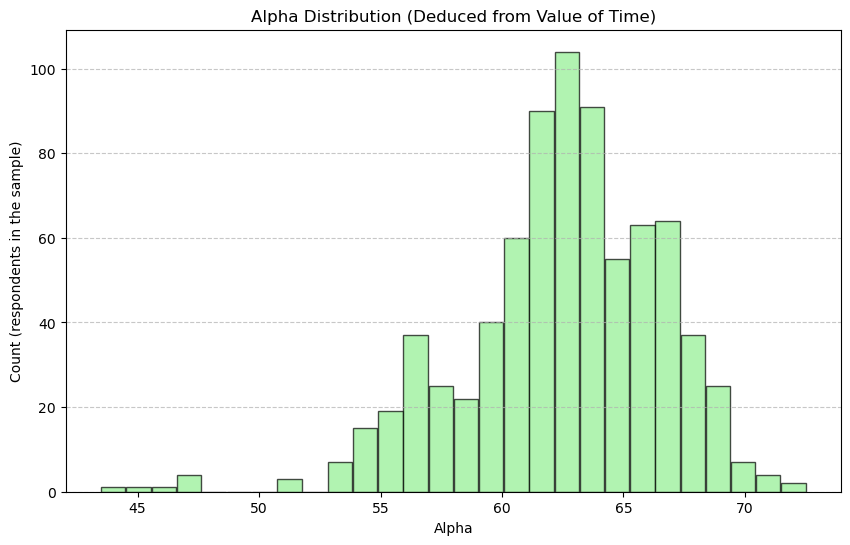

In [ ]:
delta_time = 1  # delta_time used in calculations

# Transform bin centers to represent alpha
alpha_centers = 2 * bin_centers / delta_time**2

# Plot the histogram for alpha
plt.figure(figsize=(10, 6))
plt.bar(alpha_centers, counts, width=1, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title('Alpha Distribution (Deduced from Value of Time)')
plt.xlabel('Alpha')
plt.ylabel('Count (respondents in the sample)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 3. Exploration of the Model that Fits the Data Best

### Normal, log-normal, gamma

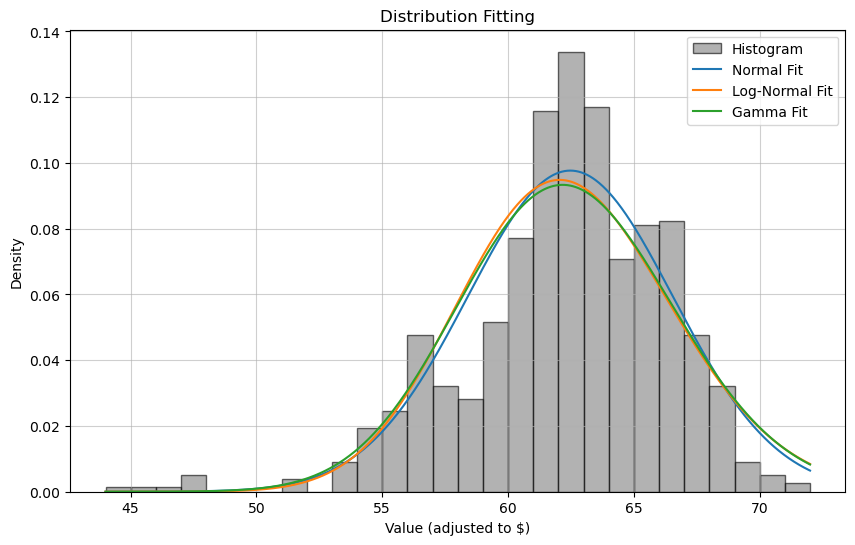

Distribution: Normal
  Parameters: (np.float64(62.473139806473135), np.float64(4.08391048632124))
  KS Statistic: 0.1157, p-value: 0.0000

Distribution: Log-Normal
  Parameters: (np.float64(0.06762268614893621), 0, np.float64(62.33383809296988))
  KS Statistic: 0.1308, p-value: 0.0000

Distribution: Gamma
  Parameters: (np.float64(265.58700732825196), np.float64(-7.323390016814487), np.float64(0.2626355293872056))
  KS Statistic: 0.1312, p-value: 0.0000



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm, gamma, kstest

# Data (using alpha centers and counts from earlier)
data = np.repeat(alpha_centers, counts)  # Expand data based on counts

# Candidate distributions to test
distributions = {
    'Normal': norm,
    'Log-Normal': lognorm,
    'Gamma': gamma
}

# Store results
fit_results = {}

# Fit each distribution and calculate metrics
for name, dist in distributions.items():
    if name == 'Log-Normal':
        shape, loc, scale = dist.fit(data, floc=0)  # Log-normal requires non-negative values
        params = (shape, loc, scale)
    else:
        params = dist.fit(data)
    
    # Compute the PDF for visualization
    pdf_x = np.linspace(min(data), max(data), 1000)
    pdf_y = dist.pdf(pdf_x, *params)
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_p = kstest(data, lambda x: dist.cdf(x, *params))
    
    # Store results
    fit_results[name] = {
        'params': params,
        'ks_stat': ks_stat,
        'ks_p': ks_p,
        'pdf_x': pdf_x,
        'pdf_y': pdf_y
    }

# Plot histogram and fitted distributions
plt.figure(figsize=(10, 6))
plt.hist(data, bins=28, density=True, alpha=0.6, color='gray', edgecolor='black', label='Histogram')

for name, result in fit_results.items():
    plt.plot(result['pdf_x'], result['pdf_y'], label=f'{name} Fit')

plt.title('Distribution Fitting')
plt.xlabel('Alpha')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.6)
plt.show()

# Compare fits
for name, result in fit_results.items():
    print(f"Distribution: {name}")
    print(f"  Parameters: {result['params']}")
    print(f"  KS Statistic: {result['ks_stat']:.4f}, p-value: {result['ks_p']:.4f}")
    print()

### GMM

c:\Users\sabri\miniconda3\envs\v2g\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\sabri\miniconda3\envs\v2g\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\sabri\miniconda3\envs\v2g\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\sabri\miniconda3\envs\v2g\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans 

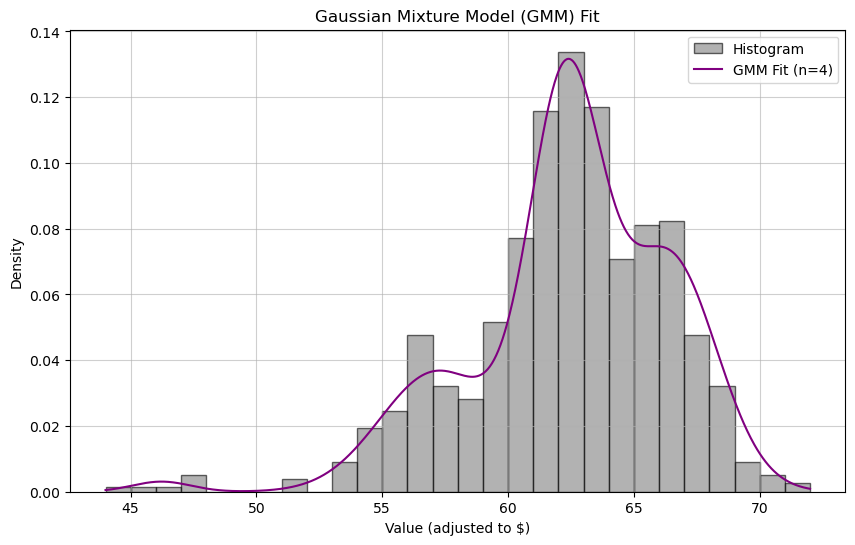

Best GMM:
  Number of Components: 4
  BIC: 4350.304519552161
  KS Statistic: 0.0722, p-value: 0.0006


In [ ]:
from sklearn.mixture import GaussianMixture
from scipy.stats import kstest, norm
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

# Prepare the data for GMM fitting
data = np.repeat(alpha_centers, counts)  # Expanded data

# Fit GMM with varying number of components and compute BIC/AIC
gmm_results = {}
best_gmm = None
best_bic = np.inf
n_components_range = range(1, 6)  # Test 1 to 5 components

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data.reshape(-1, 1))
    bic = gmm.bic(data.reshape(-1, 1))
    aic = gmm.aic(data.reshape(-1, 1))
    gmm_results[n_components] = {
        'model': gmm,
        'bic': bic,
        'aic': aic,
        'weights': gmm.weights_,
        'means': gmm.means_.flatten(),
        'covariances': gmm.covariances_.flatten(),
    }
    if bic < best_bic:
        best_bic = bic
        best_gmm = gmm

# Extract the best GMM
best_n_components = best_gmm.n_components
best_gmm_pdf_x = np.linspace(min(data), max(data), 1000)

# Define the CDF for the best GMM
def gmm_cdf(x):
    x = np.atleast_1d(x)  # Ensure x is treated as an array
    return np.array([
        np.sum([
            weight * norm.cdf(val, mean, np.sqrt(cov))
            for weight, mean, cov in zip(
                best_gmm.weights_,
                best_gmm.means_.flatten(),
                best_gmm.covariances_.flatten()
            )
        ])
        for val in x
    ])

# Statistical comparison using the Kolmogorov-Smirnov test
ks_stat_gmm, ks_p_gmm = kstest(data, gmm_cdf)

# Plot the histogram and best GMM fit
best_gmm_pdf_y = np.exp(best_gmm.score_samples(best_gmm_pdf_x.reshape(-1, 1)))

plt.figure(figsize=(10, 6))
plt.hist(data, bins=28, density=True, alpha=0.6, color='gray', edgecolor='black', label='Histogram')
plt.plot(best_gmm_pdf_x, best_gmm_pdf_y, label=f'GMM Fit (n={best_n_components})', color='purple')
plt.title('Gaussian Mixture Model (GMM) Fit')
plt.xlabel('Alpha')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.6)
plt.show()

# Compare BIC and goodness of fit
print("Best GMM:")
print(f"  Number of Components: {best_n_components}")
print(f"  BIC: {best_bic}")
print(f"  KS Statistic: {ks_stat_gmm:.4f}, p-value: {ks_p_gmm:.4f}")

In [ ]:
# Save GMM Model
import pickle

model_dir = "../models/"

best_gmm_path = os.path.join(model_dir, f"gmm_alpha.pkl")
with open(best_gmm_path, "wb") as f:
    pickle.dump(best_gmm, f)

print(f"Best GMM model with {best_n_components} components saved to {best_gmm_path}")

Best GMM model with 4 components saved to ../models/gmm_value_of_time.pkl
